# Компьютерный практикум 2023-2024

### Используемые модули

- `numpy`
- `numba`
- `holoviews` (`bokeh`/`matplotlib`)
- `tqdm`


### Задача о распространении тепла

**Дано:**

Изолированный бокс, в котором расположена текстолитовая подложка, покрытая медным слоем.
Размеры подложки: $100$ $мм$ х $50$ $мм$.

На подложке расположены:

Прибор А:
- рассеивает тепло на медном слое величиной $\frac{\dot{q}}{c_p \rho} = 100$ $К / с$
- размеры $5$ $мм$ x $5$ $мм$
- координаты центра: ($25$ $мм$, $35$ $мм$)

Прибор Б:
- координаты центра: ($75$ $мм$, $15$ $мм$),
- размером можно пренебречь,
- запрещено нагревать более, чем на $10$ градусов в течение $100$ секунд.

Посередине подложки ($x = 50$ $мм$) находится вертикальный ряд из $n$ отверстий размерами $1.5$ $мм$ x $2$ $мм$.
Отверстия:
- ухудшают механические свойства подложки, поэтому их должно быть минимальное количество.
- затрудняют передачу тепла от прибора А к прибору Б, и чем их больше, тем меньшее кол-во тепла будет передано.


**Необходимо** рассчитать минимальное количество отверстий $n$, при котором нагрев прибора Б не превысит $10$ градусов за $100$ секунд.

### Теоретическое введение

Распространение тепла можно описать при помощи уравнения диффузии (двумерный случай):

$\frac{\partial{T}}{\partial{t}} = D \left(\frac{\partial^2{T}}{\partial{x^2}} + \frac{\partial^2{T}}{\partial{y^2}} \right) + \frac{1}{c_p \rho} \cdot \dot{q}$, где

- $T(t, x, y)$ - поле температур
- $D(x, y)$ - коэффициент диффузии
- $\dot q(t, x, y)$ - функция источников тепла

Для решения задачи распространения тепла рассматриваемое тело представляют в виде двумерной сетки с равномерным шагом, а дифференциальное уравнение заменяют на конечно-разностное.
Рассмотрим схему `FTCS`, т.е. производная по времени заменяется на правую разность (`Forward Time`), а вторая производная по пространственным переменным заменяется на центральную разность (`Central Space`).

$\frac{\partial{T}}{\partial{t}} \rightarrow \frac{T^{n}_{i,j} - T^{n-1}_{i,j}}{dt}$

$\frac{\partial^2{T}}{\partial{x^2}} \rightarrow \frac{T^{n-1}_{i-1,j} - 2T^{n-1}_{i,j} + T^{n-1}_{i+1,j}}{dx^2}, ...$

$\frac{T^{n}_{i,j} - T^{n-1}_{i,j}}{dt} = \frac{D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{1}{c_p \rho} \cdot \dot{q}$

Итоговая рекуррентная формула для вычисления температуры в момент времени $n \cdot dt$ в ячейке сетки $(i, j)$ на основании данных в момент времени $(n-1) \cdot dt$:

$T^{n}_{i,j} = T^{n-1}_{i,j} + \frac{dt D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{dt}{c_p \rho} \cdot \dot{q}^{n}_{i,j}$

Временной шаг $dt$ должен быть таким, чтобы учитывать условие Курранта: $dt \leq \frac{C \cdot dx^2}{D_{max}}$, где $C$ - число Курранта.

В этой задаче рассматриваются граничные условия двух видов - фиксированная температура и абсолютная теплоизоляция. Оба вида граничных условий указаны на ребрах прямоугольной области. Таким образом, расчет распространения тепла выполняется для всех ячеек сетки, за исключением расположенных на ребрах прямоугольной области, т.е. $i, j \in (0, N-1)$, где $N = L / dx$.

Граничное условие в виде фиксированной температуры записывается в ячейки сетки, соответствующие ребрам прямоугольной области:

Например, для грани $x = 0$: $T^{n}_{0,j} = T_*$, грани $x = L$: $T^{n}_{N-1,j} = T_*$. 


Граничное условие в виде абсолютной теплоизоляции означает, что через заданную грань нет потока тепла, а это достижимо, если температура в ячейках грани и прилегающим к ним ячейкам одинаковая:

Например, $x = 0$: $T^{n}_{0,j} = T^{n}_{1,j}$, грани $x = L$: $T^{n}_{N-1,j} = T^{n}_{N-2,j}$.

$D = \frac{\kappa}{c_p \rho}$

- $\kappa$ - коэфф. теплопроводности
- $c_p$ - удельная теплоемкость
- $\rho$ - плотность

### Коэффициент температуропроводности материалов

$D_{медь} = 1.11 \cdot 10^{-4}$ $м^2 / c$

$D_{текстолит} = 1.54 \cdot 10^{-7}$ $м^2 / c$


### Ссылки

- [Solving 2D Heat Equation Numerically using Python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)

# Тестовая задача

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
nx, ny = 200, 200
dx = 1.0
D = 1.0
C = 0.1
dt = C * dx**2 / D

In [15]:
T = np.zeros((2, ny, nx))

# граничные условия
T[:, :, 0] = 1000.0
T[:, 0, :] = 500.0

In [16]:
def diffuse_step(
    it: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    D: float
):
    # it = 0: T[0] -> T[1]
    # it = 1: T[1] -> T[0]
    prev = it % 2
    #cur  = (it + 1) % 2
    cur  = prev - 1
    g = dt * D / dx**2
    
    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + g * (
        T[prev, 1:-1, 0:-2] + 
        T[prev, 1:-1, 2:  ] + 
        T[prev, 0:-2, 1:-1] + 
        T[prev, 2:,   1:-1] -
        4 * T[prev, 1:-1, 1:-1]
    )

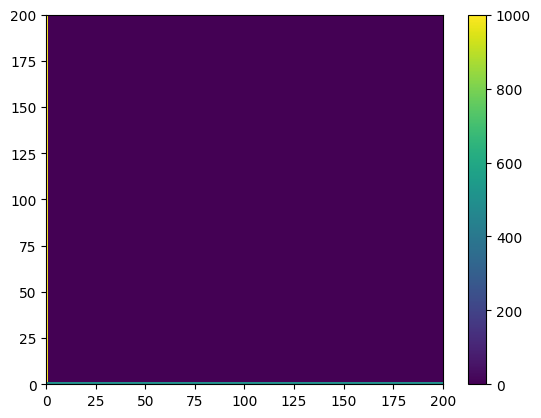

In [17]:
plt.pcolormesh(T[0])
plt.colorbar()

In [18]:
for it in range(10000):
    diffuse_step(it, T, dx, dt, D)

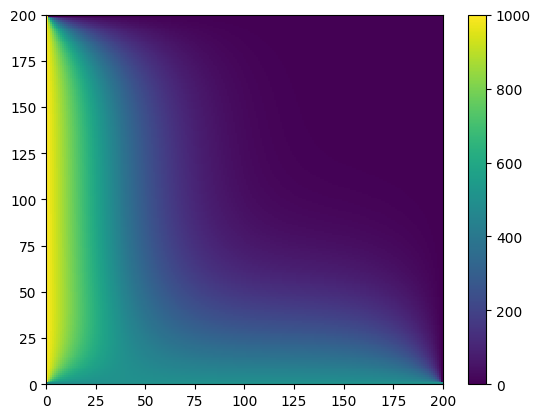

In [19]:
plt.pcolormesh(T[0])
plt.colorbar()

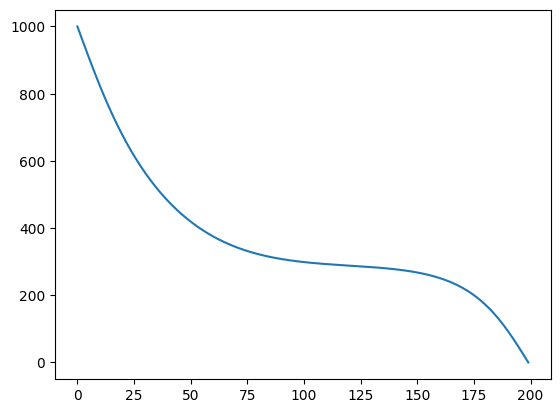

In [20]:
plt.plot(np.arange(nx)*dx, T[0, 25])

# Основная задача

In [21]:
L, H = 0.1, 0.05  # м
nx, ny = 200, 100
dx = L / nx
Dcu = 1.11e-4  # м^2/с
Dtex = 1.54e-7

hx=3, hy=4


(0.0, 200.0, 0.0, 100.0)

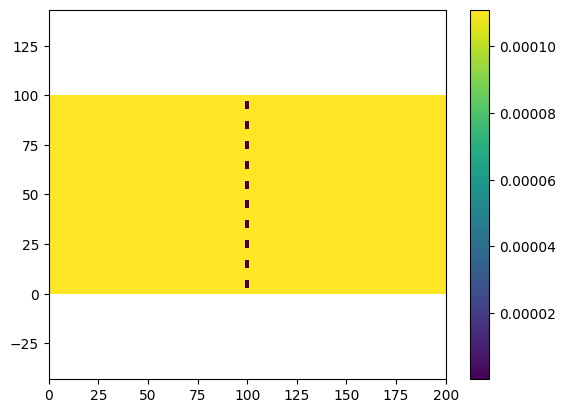

In [35]:
Dij = np.full((ny, nx), Dcu)
hx = int(1.5 / 1000 / dx)
hy = int(2.0 / 1000 / dx)
print(f"{hx=}, {hy=}")

n = 10
dh = ny // n
for i in range(n):
    Dij[ 
        dh // 2 + dh*i - hy // 2: dh // 2 + dh*i + hy // 2,
        nx // 2 - hx // 2: nx // 2 + hx // 2
    ] = Dtex

plt.pcolormesh(Dij)
plt.colorbar()
plt.axis('equal')